In [1]:
!pip install tensorflow==2.0.0
!pip install imutils
!pip install python-telegram-bot #For training updates on Telegram

import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dropout, MaxPooling2D, AveragePooling2D, Dense, Flatten, Input, Conv2D, add, Activation
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input)

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from PIL import Image
import matplotlib.pyplot as plt

import cv2
from imutils import paths
import numpy as np
import os
import time
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 86.3 MB 50 kB/s 
     |████████████████████████████████| 3.8 MB 50.9 MB/s 
     |████████████████████████████████| 50 kB 5.2 MB/s 
     |████████████████████████████████| 449 kB 52.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=1d0f11427ddef58f989c239b1795ca5a5f4f34940f9183defba2d473542084ea
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalle

In [2]:
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.0.0


# **Creating class for Telegram Bot Message Updates along with Graph**

For complete guidanc and example of making Telegram bot visit here:<br>
https://github.com/OMIII1997/Telegram-Bot-for-Model-Training-Updates <br>

Get access_token from Telegram app: 
* Open Telegram mobile app 
* Search for "BotFather" 
* Send "/start"
* After reply from BotFather send "/newbot"
* Give name to your Bot Eg: Example_Bot
* Give username to your Bot Eg: My_Example_bot *Note: User name must end with '_bot'* 
* Done...Congratulations You have crated your own Telegram bot. Now you will get Token to access the HTTP API. Copy that Token Key.

In [3]:
import requests
import tensorflow as tf

import tensorflow.keras.utils as np_utils

access_token = '' #Access token here

class botCallback(tf.keras.callbacks.Callback):
    def __init__(self,access_token):
        self.access_token = access_token
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/getUpdates'
        self.response = requests.get(self.ping_url).json()
        #print(self.response)
        self.chat_id = self.response['result'][0]['message']['chat']['id']
        #self.chat_id = self.response['result']

    def send_message(self,message):
        #print('sending message')
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/sendMessage?'+\
                        'chat_id='+str(self.chat_id)+\
                        '&parse_mode=Markdown'+\
                        '&text='+message
        self.response = requests.get(self.ping_url)
    
    def send_photo(self,filepath):
        imagefile= open(filepath,"rb")
        file_dict = {'photo':imagefile}
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/sendPhoto?chat_id='+str(self.chat_id)
        self.response = requests.post(self.ping_url, files = file_dict)
        imagefile.close()

    def on_train_batch_begin(self, batch, logs=None):
        pass
    
    def on_train_batch_end(self, batch, logs=None):
        message = ' Iteration/Batch {}\n Training Accuracy : {:7.2f}\n Training Loss : {:7.2f}\n'.format(batch,logs['accuracy'],logs['loss'])
        #print(logs)
        try:
            message += ' Validation Accuracy : {:7.2f}\n Validation Loss : {:7.2f}\n'.format(logs['val_accuracy'],logs['val_loss'])
            self.send_message(message)
        except:
            pass

    def on_test_batch_begin(self, batch, logs=None):
        pass
    
    def on_test_batch_end(self, batch, logs=None):
        message = ' Iteration/Batch {}\n Training Accuracy : {:7.2f}\n Training Loss : {:7.2f}\n'.format(batch,logs['accuracy'],logs['loss'])
        try:
            message += ' Validation Accuracy : {:7.2f}\n Validation Loss : {:7.2f}\n'.format(logs['val_accuracy'],logs['val_loss'])
            self.send_message(message)
        except:
            pass

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):

        message = ' Epoch {}\n Training Accuracy : {:7.2f}\n Training Loss : {:7.2f}\n'.format(epoch,logs['accuracy'],logs['loss'])
        try:
            message += ' Validation Accuracy : {:7.2f}\n Validation Loss : {:7.2f}\n'.format(logs['val_accuracy'],logs['val_loss'])
            self.send_message(message)        
        except:
            pass

class Plotter(botCallback):
 def __init__(self,access_token):
    
     super().__init__(access_token)
 def on_train_begin(self,logs=None):
     self.batch = 0
     self.epoch = []
     self.train_loss = []
     self.val_loss = []
     self.train_acc = []
     self.val_acc = []
     self.fig = plt.figure(figsize=(200,100))
     self.logs = []

 def on_epoch_end(self, epoch, logs=None):
     self.logs.append(logs)
     self.epoch.append(epoch)
     self.train_loss.append(logs['loss'])
     self.val_loss.append(logs['val_loss'])
     self.train_acc.append(logs['accuracy'])
     self.val_acc.append(logs['val_accuracy'])
     f,(ax1,ax2) = plt.subplots(1,2,sharex=True)
     #clear_output(wait=True)
     ax1.plot(self.epoch, self.train_loss, label='Training Loss')
     ax1.plot(self.epoch, self.val_loss, label='Validation Loss')
     ax1.legend()
     ax2.plot(self.epoch, self.train_acc, label='Training Accuracy')
     ax2.plot(self.epoch, self.val_acc, label='Validation Accuracy')
     ax2.legend()
     plt.savefig('Accuracy and Loss plot.jpg')
     self.send_photo('Accuracy and Loss plot.jpg')

In [4]:

train_dir = '/kaggle/input/soil-classification-image-data/Soil_Dataset/Train'
test_dir = '/kaggle/input/soil-classification-image-data/Soil_Dataset/Test'

image_size = 224

In [5]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255,
                            rotation_range=45,
                            zoom_range=0.40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            vertical_flip= True,
                            fill_mode="nearest")

train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(150,150),
                                              batch_size=32,
                                              class_mode="categorical")


Found 715 images belonging to 4 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=(150,150),
                                            batch_size=32,
                                            class_mode="categorical")

Found 188 images belonging to 4 classes.


Model: "SoilNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        6560

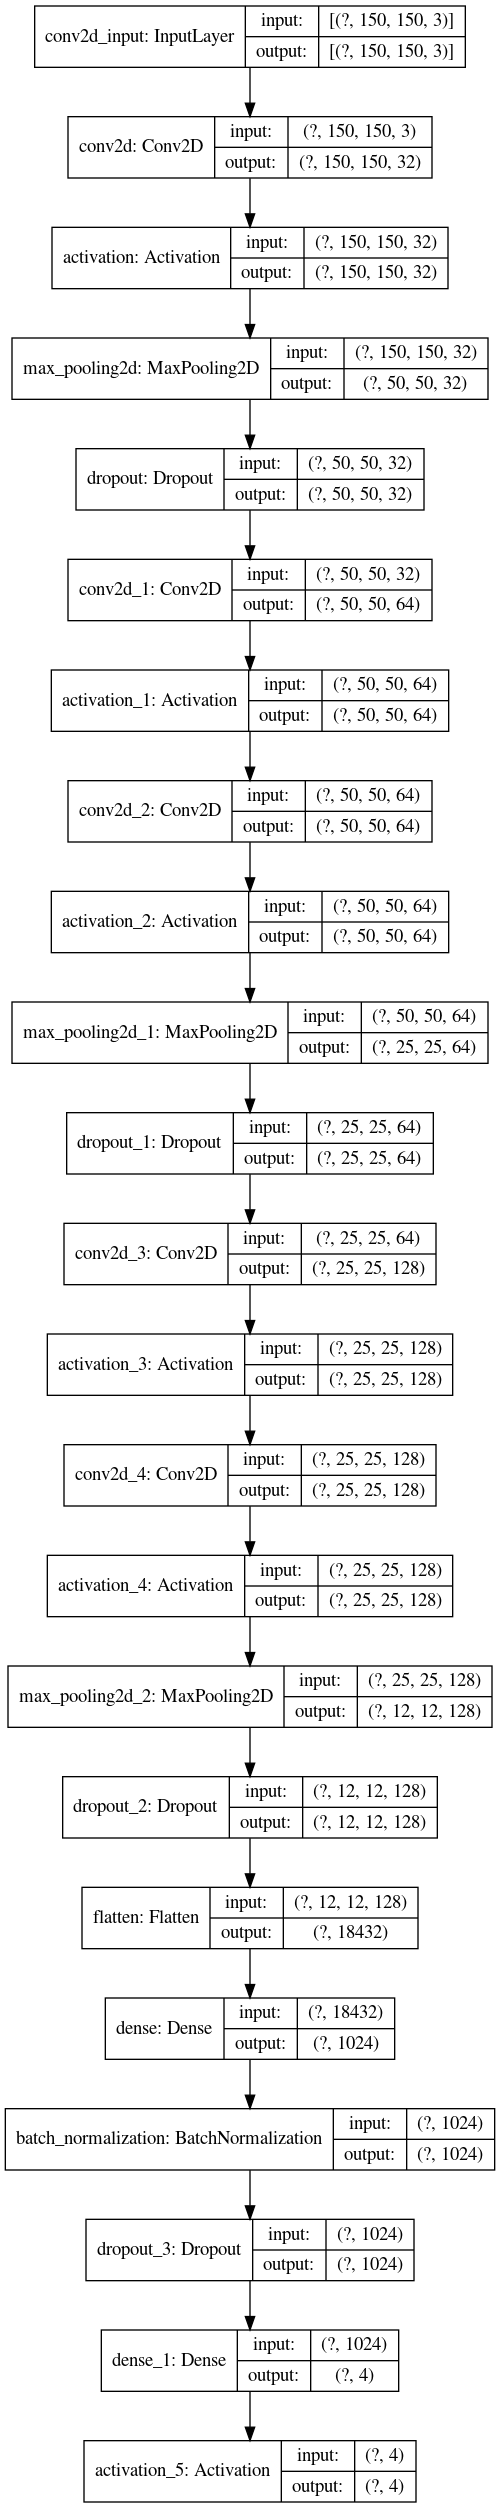

In [7]:

#=================================================================
chanDim = 1
model = Sequential(name="SoilNet")
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(150,150,3)))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (4, 4), padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(64, (4, 4), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (4, 4), padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(128, (4, 4), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation("softmax"))


model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
reduction_lr = ReduceLROnPlateau(monitor = "val_accuracy",patience = 2 ,verbose = 1, factor = 0.2, min_lr = 0.00001)
model.summary()
plot_model(model,show_shapes=True)


In [8]:
callback_list = [reduction_lr]

In [9]:
#bot_callback = botCallback(access_token)
#plotter = Plotter(access_token)
#callback_list = [bot_callback,plotter] callbacks=callback_list
start = time.time()

history = model.fit_generator(train_data,
                    steps_per_epoch = 30,
                    validation_data = test_data,
                    validation_steps = 30,
                    epochs=20,
                    callbacks = callback_list)
end = time.time()
print("Total train time: ",(end-start)/60," mins")

Epoch 1/20
30/30 [==============================] - 127s 4s/step - loss: 1.6986 - accuracy: 0.6635 - val_loss: 10.5414 - val_accuracy: 0.3138
Epoch 2/20
30/30 [==============================] - 114s 4s/step - loss: 0.9081 - accuracy: 0.7941 - val_loss: 4.6568 - val_accuracy: 0.5266
Epoch 3/20
30/30 [==============================] - 112s 4s/step - loss: 0.5484 - accuracy: 0.7955 - val_loss: 0.8508 - val_accuracy: 0.7553
Epoch 4/20
30/30 [==============================] - 110s 4s/step - loss: 0.4851 - accuracy: 0.8211 - val_loss: 3.1642 - val_accuracy: 0.4840
Epoch 5/20
29/30 [============================>.] - ETA: 2s - loss: 0.4300 - accuracy: 0.8363
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
30/30 [==============================] - 107s 4s/step - loss: 0.4273 - accuracy: 0.8366 - val_loss: 0.6723 - val_accuracy: 0.7500
Epoch 6/20
30/30 [==============================] - 110s 4s/step - loss: 0.3249 - accuracy: 0.8786 - val_loss: 0.5604 - val_accura

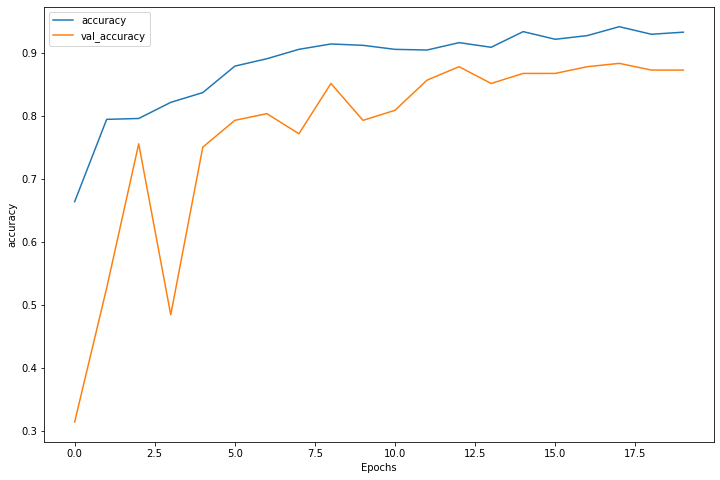

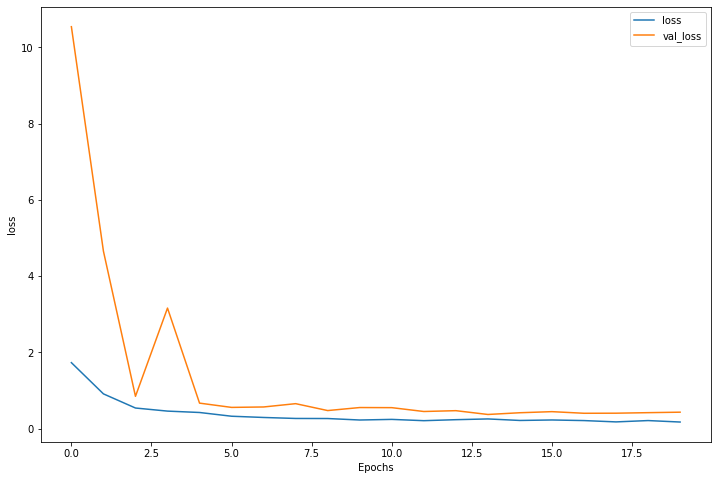

In [10]:
def plot_graph(history,string):
    plt.figure(figsize=(12,8))
    plt.plot(history.history[string],label=str(string))
    plt.plot(history.history["val_"+str(string)],label="val_"+str(string))
    plt.xlabel("Epochs")
    plt.ylabel(str(string))
    plt.legend()
    plt.show()
plot_graph(history,"accuracy")
plot_graph(history,"loss")

In [11]:
model.save("SoilNet.h5")

In [12]:
from IPython.display import FileLink
FileLink('SoilNet.h5')


/kaggle/working/SoilNet.h5